In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.0.0


In [2]:
# 1.1
# Reading HDF5 files
train_data   = pd.read_hdf("X_train.hdf")
train_labels = pd.read_hdf("y_train.hdf")
test_data    = pd.read_hdf("X_test.hdf")
test_labels  = pd.read_hdf("y_test.hdf")

In [3]:
print(train_data)

                          ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000       

In [4]:
print(train_labels)

                          mortalityResponse
encounterID absoluteTime                   
8           0.000000                      1
            0.250000                      1
            0.500000                      1
            0.583333                      1
            0.750000                      1
...                                     ...
16259       87.000000                     1
            87.083336                     1
            87.666664                     1
            88.000000                     1
            89.000000                     1

[1113529 rows x 1 columns]


In [5]:
print(test_data)

                          ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
19          0.000000                          NaN       NaN               NaN   
            0.016667                          NaN       NaN               NaN   
            0.766667                          NaN       NaN               NaN   
            0.983333                          NaN       NaN               NaN   
            1.000000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16266       8.833333                          NaN       NaN               NaN   
            9.666667                          NaN       NaN               NaN   
            10.666667                         NaN       NaN               NaN   
            11.250000                         NaN       NaN               NaN   
            11.666667       

In [6]:
print(test_labels)

                          mortalityResponse
encounterID absoluteTime                   
19          0.000000                      1
            0.016667                      1
            0.766667                      1
            0.983333                      1
            1.000000                      1
...                                     ...
16266       8.833333                      1
            9.666667                      1
            10.666667                     1
            11.250000                     1
            11.666667                     1

[82251 rows x 1 columns]


In [7]:
# 1.2
encounters = set()
for i in range(train_data.index.shape[0]):
    encounters.add(train_data.index.values[i][0])
len(encounters)
print("Number of patient encounters in training set =", len(encounters))
print("Number of timestamps measured in total =", train_data.index.shape[0])
print("Number of types of measurements documented =", train_data.columns.shape[0])

Number of patient encounters in training set = 5000
Number of timestamps measured in total = 1113529
Number of types of measurements documented = 265


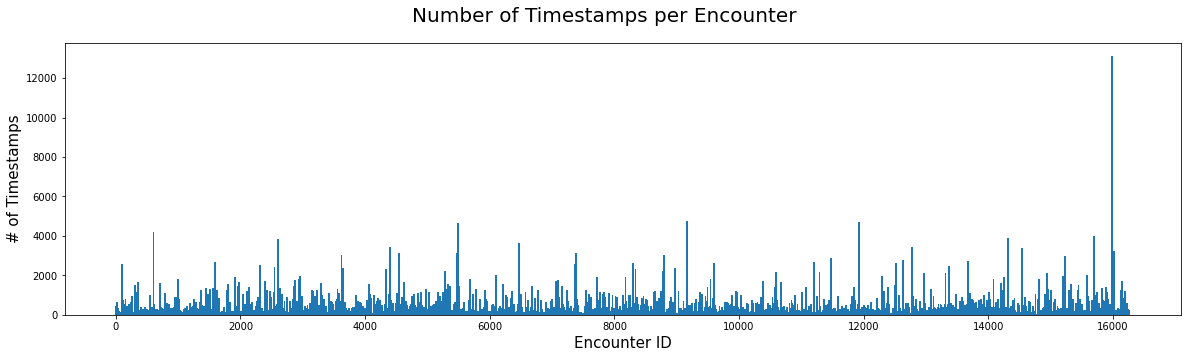

In [8]:
# 1.3
encounterStampMap = dict()
for i in train_data.index:
    if i[0] not in encounterStampMap.keys():
        encounterStampMap[i[0]] = 1
    else:
        encounterStampMap[i[0]] += 1
        
# Plotting histogram
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Number of Timestamps per Encounter', fontsize=20)
plt.bar(encounterStampMap.keys(), encounterStampMap.values(), width=30)
plt.xlabel("Encounter ID", fontsize=15)
plt.ylabel("# of Timestamps", fontsize=15)
plt.show()

In [9]:
# 1.4
# Normalizing the data
mean = train_data.values.mean(axis=0)
std = train_data.values.std(axis=0)

norm_train_data = train_data.values - mean
norm_test_data  = test_data.values - mean

norm_train_data /= std
norm_test_data /= std

In [10]:
# 1.5 (HORIZONTAL FORWARD FILL)
encounterTracker = 0
# Forward filling training set
for measurement in norm_train_data:
    currentValue = 0
    for index, value in enumerate(measurement):
        if math.isnan(value):
            measurement[index] = currentValue
        else:
            currentValue = value

# Forward filling testing set
for measurement in norm_test_data:
    currentValue = 0
    for index, value in enumerate(measurement):
        if math.isnan(value):
            measurement[index] = currentValue
        else:
            currentValue = value

In [11]:
# 1.6 
# Find 90th Percentile of Length
maxSeqLen = 0
for limit in range(1, 1000):
    localCounter = 0
    for value in encounterStampMap.values():
        if(value <= limit):
            localCounter += 1
    
    if (localCounter/len(encounterStampMap)) == 0.9:
        maxSeqLen = limit
        print("90th Percentile of Length =", maxSeqLen)
        break

train_data_Seq = np.zeros((len(encounterStampMap), maxSeqLen, norm_train_data[0].shape[0])) # (5000, 523, 265)
train_labels_Seq = np.zeros((len(encounterStampMap), 1)) # (5000, 1) 
lowerIndex = 0
upperIndex = 0
for index, value in enumerate(encounterStampMap.values()): # Iterate through number of timestampes per ID
    upperIndex = upperIndex + value
    if(value <= maxSeqLen):
        train_data_Seq[index][0:upperIndex-lowerIndex] = norm_train_data[lowerIndex:upperIndex]
        train_labels_Seq[index] = train_labels.values[upperIndex-1][0]
    if(value > maxSeqLen):
        train_data_Seq[index] = norm_train_data[lowerIndex:lowerIndex+maxSeqLen]
        train_labels_Seq[index] = train_labels.values[lowerIndex+maxSeqLen-1][0]
    lowerIndex = lowerIndex + value
    
print("Unifrom Train Data Sequence Shape =", train_data_Seq.shape)
print("Train Labels Sequence Shape =", train_labels_Seq.shape)

90th Percentile of Length = 523
Unifrom Train Data Sequence Shape = (5000, 523, 265)
Train Labels Sequence Shape = (5000, 1)


In [21]:
# 2.1 a
# Model definition
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128, input_shape=(train_data_Seq.shape[1], train_data_Seq.shape[2])))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

# Build model
model = build_model()

# Summary of our model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               201728    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 2.1 b
# Train Model

# Get random training and validating data (4:1)
partial_train_data, val_data, partial_train_labels, val_labels = train_test_split(train_data_Seq, 
                                                                                  train_labels_Seq, 
                                                                                  test_size=0.2)

# Fit model
num_epochs = 10
history = model.fit(partial_train_data, partial_train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=num_epochs, verbose = 1)

# Plotting Results
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
fig.add_subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 313s 78ms/sample - loss: 0.1960 - acc: 0.9457 - val_loss: 0.1884 - val_acc: 0.9550
Epoch 2/20
4000/4000 [==============================] - 272s 68ms/sample - loss: 0.1753 - acc: 0.9530 - val_loss: 0.1824 - val_acc: 0.9550
Epoch 3/20
4000/4000 [==============================] - 271s 68ms/sample - loss: 0.1739 - acc: 0.9542 - val_loss: 0.1794 - val_acc: 0.9550
Epoch 4/20
4000/4000 [==============================] - 272s 68ms/sample - loss: 0.1717 - acc: 0.9557 - val_loss: 0.1809 - val_acc: 0.9550
Epoch 5/20
4000/4000 [==============================] - 266s 67ms/sample - loss: 0.1733 - acc: 0.9557 - val_loss: 0.1784 - val_acc: 0.9550
Epoch 6/20
4000/4000 [==============================] - 280s 70ms/sample - loss: 0.1706 - acc: 0.9557 - val_loss: 0.1799 - val_acc: 0.9550
Epoch 7/20
4000/4000 [==============================] - 240s 60ms/sample - loss: 0.1740 - acc: 0.9550 - val_loss: 0.17

KeyboardInterrupt: 

In [16]:
##### IGNORE #####

# # 1.5 (VERTICAL FORWARD FILL)
# timestampCountList = list()
# for key in encounterStampMap:
#     timestampCountList.append(encounterStampMap[key])

# currentValue = np.zeros(norm_train_data[0].shape)
# timestampTracker = 0
# encounterIDTracker = 0
# # Forward filling training set
# for measurement in norm_train_data:
#     if(timestampTracker == timestampCountList[encounterIDTracker]):
#         currentValue = np.zeros(norm_train_data[0].shape)
#         timestampTracker = 0
#         encounterIDTracker += 1
        
#     for index, value in enumerate(measurement):
#         if math.isnan(value):
#             measurement[index] = currentValue[index]
#         else:
#             currentValue[index] = value
            
#     timestampTracker += 1

# currentValue = np.zeros(norm_train_data[0].shape)
# timestampTracker = 0
# encounterIDTracker = 0
# # Forward filling testing set
# for measurement in norm_test_data:
#     if(timestampTracker == timestampCountList[encounterIDTracker]):
#         currentValue = np.zeros(norm_train_data[0].shape)
#         timestampTracker = 0
#         encounterIDTracker += 1
        
#     for index, value in enumerate(measurement):
#         if math.isnan(value):
#             measurement[index] = currentValue[index]
#         else:
#             currentValue[index] = value
            
#     timestampTracker += 1